In [1]:
# Author: Jaehun Kim
# Email: rlawogns1204@unist.ac.kr
# Affiliation: UNIST BME BCILAB
# Date: 2023-06-26
#
# This code implements a tactile information processing model using a spiking
# neural network (SNN). It simulates the processing of tactile information from
# mechanoreceptors in the skin through primary afferent fibers (PA), cuneate nucleus
# neurons (PN and IN), and ultimately, somatosensory cortex neurons. The model
# incorporates lateral inhibition and various receptive field properties to
# represent a realistic processing of touch stimuli.

# with DIGIT-sensor
# pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from PIL import Image
import io
import datetime
import cv2
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from Function.snn_IZHIlayers import *
from Function.snn_plot import *
from Function.snn_simulation import *
from Function.snn_stimulation import *
from Function.snn_receptive_field_weights import *

from line_profiler import LineProfiler

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(f"Using device: {device}")\

# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16
# Set pixel dimensions (number of pixels in height and width)
# pixel_h, pixel_w = 320, 240///
pixel_h, pixel_w = 64,48
# Set image frames per second (FPS) of tactile sensor
image_FPS = 60

GPU available: False
CUDA version: None
Using device: cpu


In [2]:
R = ReceptiveFieldWeights(pixel_h, pixel_w, device, type_output = [np.pi/2], plot_receptive_field = False,plot_ind = 1)

[1.5707963267948966]
torch.Size([88, 3072])
sa_rf shape: torch.Size([88, 3072]) with height = 11 with width = 8
ra_rf shape: torch.Size([130, 3072]) with height = 13 with width = 10
sa_cn_pn_rf shape:  torch.Size([54, 88]) sa_cn_pn_step_height: 9 sa_cn_pn_step_width: 6
sa_cn_in_rf shape:  torch.Size([54, 88]) sa_cn_in_step_height: 9 sa_cn_in_step_width: 6
ra_cn_pn_rf shape:  torch.Size([88, 130]) ra_cn_pn_step_height: 11 ra_cn_pn_step_width: 8
ra_cn_in_rf shape:  torch.Size([88, 130]) ra_cn_in_step_height: 11 ra_cn_in_step_width: 8
sa_intopn_rf shape:  torch.Size([54, 54])
ra_intopn_rf shape:  torch.Size([88, 88])
cn_pn_sa_rf shape:  torch.Size([28, 54]) cn_pn_sa_rf_step_height: 7 cn_pn_sa_rf_step_width: 4
cn_in_sa_rf shape:  torch.Size([28, 54]) cn_in_sa_rf_step_height: 7 cn_in_sa_rf_step_width: 4
cn_pn_ra_rf shape:  torch.Size([28, 88]) cn_pn_ra_rf_step_height: 7 cn_pn_ra_rf_step_width: 4
cn_in_ra_rf shape:  torch.Size([28, 88]) cn_in_ra_rf_step_height: 7 cn_in_ra_rf_step_width: 4
cn

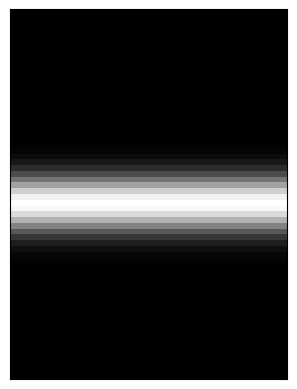

In [5]:
stim = generate_stimuli(angle = 0, num_stim = 20000, pixel_h=pixel_h, pixel_w=pixel_w, F=3, plot_stimuli=True, device = 'cpu')

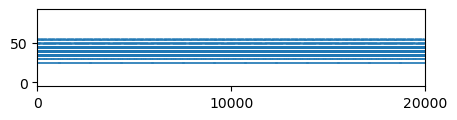

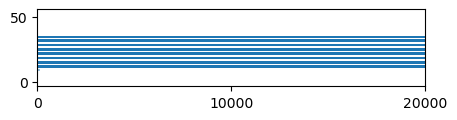

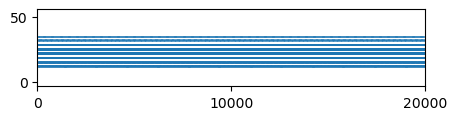

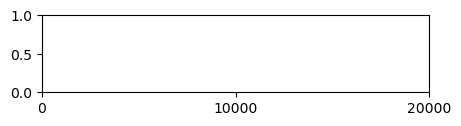

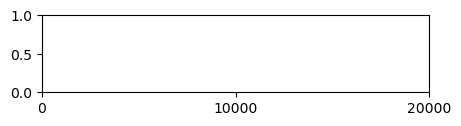

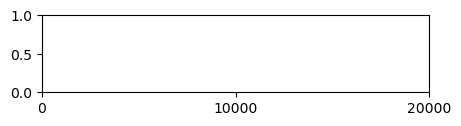

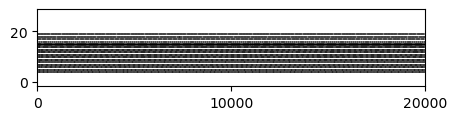

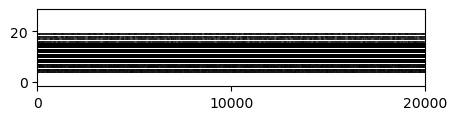

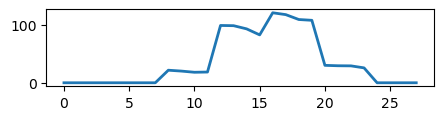

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [24]:
num_trials = 1
num_frequencies = range(1,20, 2) # Frequencies from 80 to 100 with a step of 1
num_stim = 20000
F = 5
pixel_h = 64
pixel_w = 48
device = 'cpu'  

S = SNN(R, device = device, noise_std_val = 0, a_decay = 1)  # Update with your SNN initialization method
S.feedforward(stim)

mean_firing_rates = plot_SNN(S,layers = ['sa','ra','cn'],plot_figure = True, fig_size = (5,1))

S.ra_spike_times[0]

In [25]:
total_spikes_sa0 = S.sa_spike_times[0].sum()
# total_spikes_sa1 = S.sa_spike_times[1].sum()
total_spikes_sa2 = S.sa_spike_times[2].sum()

total_spikes_ra0 = S.ra_spike_times[0].sum()
# total_spikes_ra1 = S.ra_spike_times[1].sum()
total_spikes_ra2 = S.ra_spike_times[2].sum()

# total_spikes_cn0 = S.cn_spike_times[0].sum()
total_spikes_cn1 = S.cn_spike_times[1].sum()

total_spikes_nonadaptive = total_spikes_sa0 + total_spikes_sa1 + total_spikes_sa2 + total_spikes_ra0 + total_spikes_ra1 + total_spikes_ra2 + total_spikes_cn0 + total_spikes_cn1

print(total_spikes_nonadaptive)



tensor(104350.)


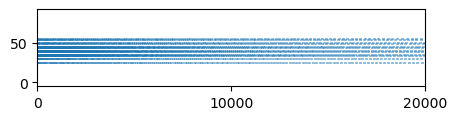

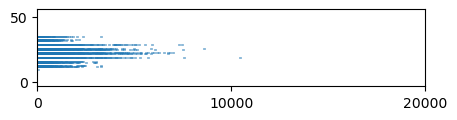

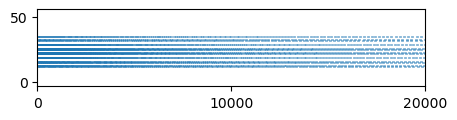

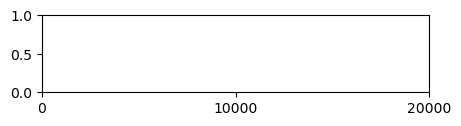

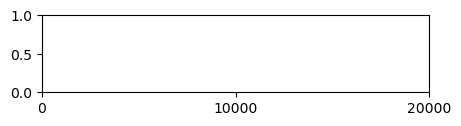

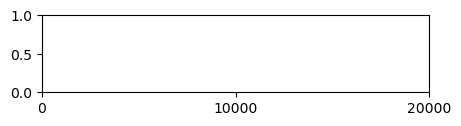

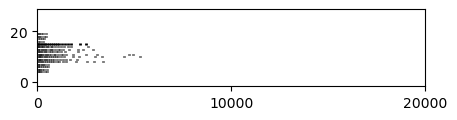

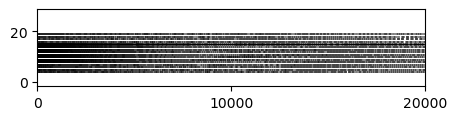

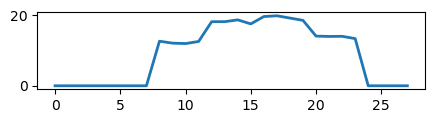

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [26]:
num_trials = 1
num_frequencies = range(1,20, 2) # Frequencies from 80 to 100 with a step of 1
num_stim = 20000
F = 5
pixel_h = 64
pixel_w = 48
device = 'cpu'  

S = SNN(R, device = device, noise_std_val = 0, a_decay = 1.01)  # Update with your SNN initialization method
S.feedforward(stim)

mean_firing_rates = plot_SNN(S,layers = ['sa','ra','cn'],plot_figure = True, fig_size = (5,1))

S.ra_spike_times[0]

In [27]:
total_spikes_sa0 = S.sa_spike_times[0].sum()
# total_spikes_sa1 = S.sa_spike_times[1].sum()
total_spikes_sa2 = S.sa_spike_times[2].sum()

total_spikes_ra0 = S.ra_spike_times[0].sum()
# total_spikes_ra1 = S.ra_spike_times[1].sum()
total_spikes_ra2 = S.ra_spike_times[2].sum()

# total_spikes_cn0 = S.cn_spike_times[0].sum()
total_spikes_cn1 = S.cn_spike_times[1].sum()

total_spikes_adaptive = total_spikes_sa0 + total_spikes_sa1 + total_spikes_sa2 + total_spikes_ra0 + total_spikes_ra1 + total_spikes_ra2 + total_spikes_cn0 + total_spikes_cn1

print(total_spikes_adaptive)


tensor(22843.)


Trials:   0%|          | 0/1 [00:00<?, ?it/s]

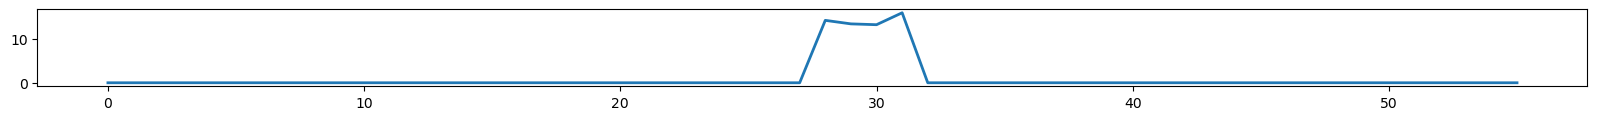

frequency:1 Hz    Mean Firing Rate(Hz): 1.0139096975326538


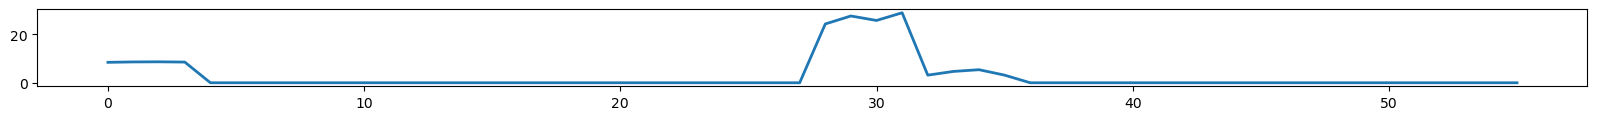

frequency:2 Hz    Mean Firing Rate(Hz): 2.812406301498413


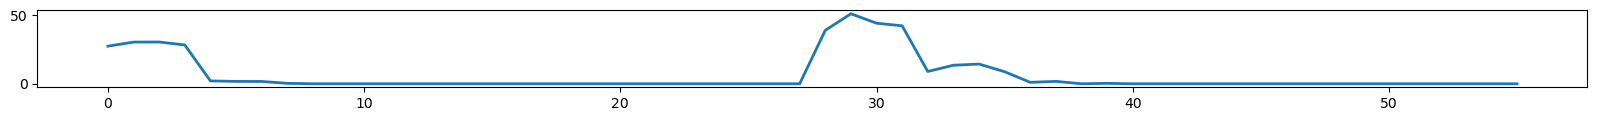

frequency:3 Hz    Mean Firing Rate(Hz): 6.217669486999512


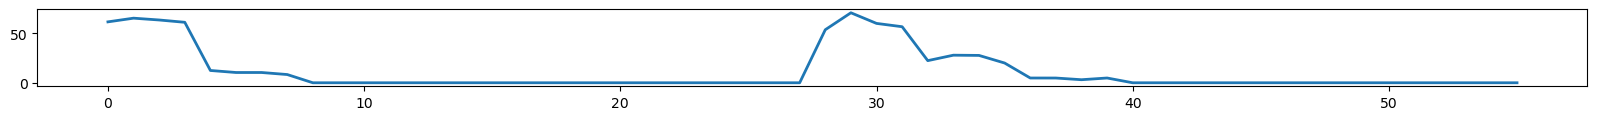

frequency:4 Hz    Mean Firing Rate(Hz): 11.590978622436523


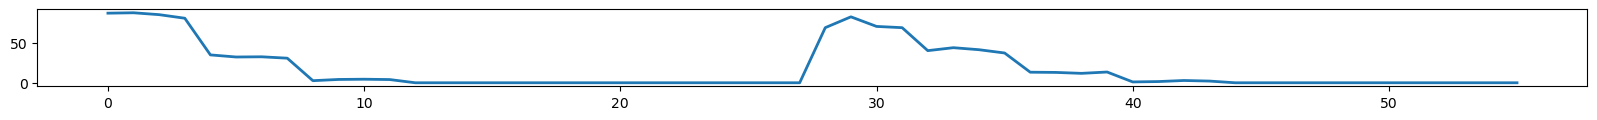

frequency:5 Hz    Mean Firing Rate(Hz): 17.710527420043945


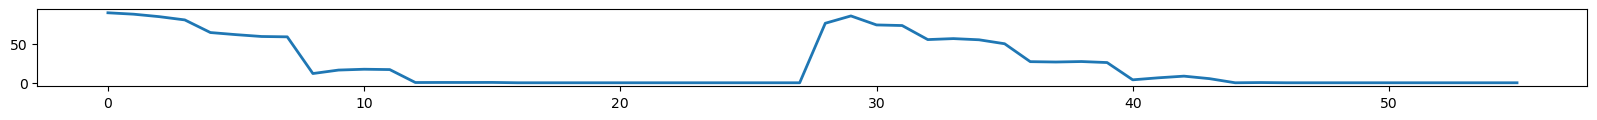

frequency:6 Hz    Mean Firing Rate(Hz): 23.500751495361328


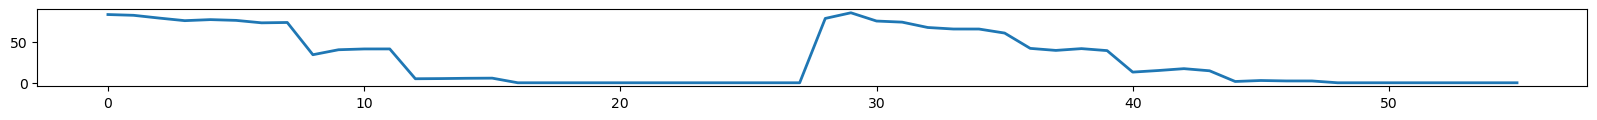

frequency:7 Hz    Mean Firing Rate(Hz): 28.57330894470215


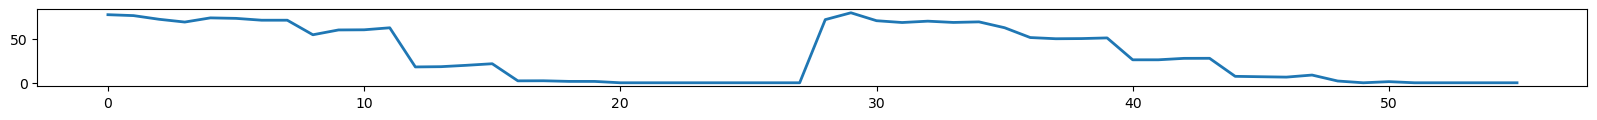

frequency:8 Hz    Mean Firing Rate(Hz): 32.548118591308594


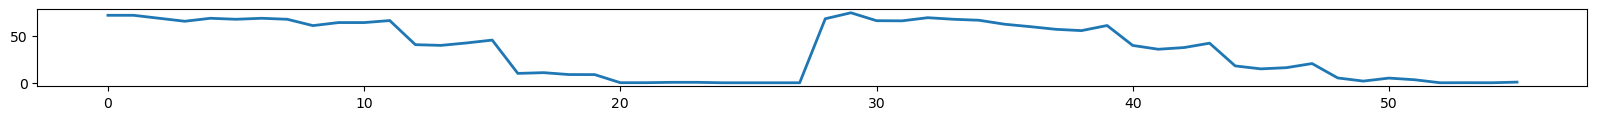

frequency:9 Hz    Mean Firing Rate(Hz): 36.070674896240234


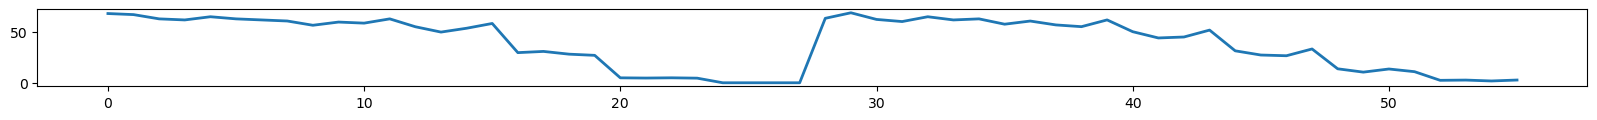

frequency:10 Hz    Mean Firing Rate(Hz): 39.54812240600586


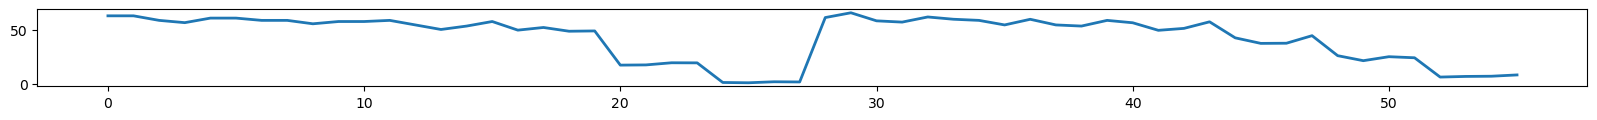

frequency:11 Hz    Mean Firing Rate(Hz): 43.279327392578125


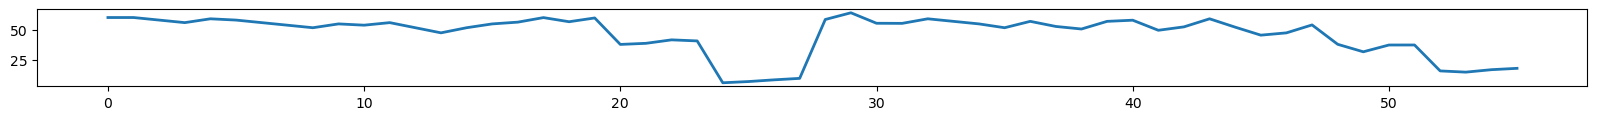

frequency:12 Hz    Mean Firing Rate(Hz): 46.48383331298828


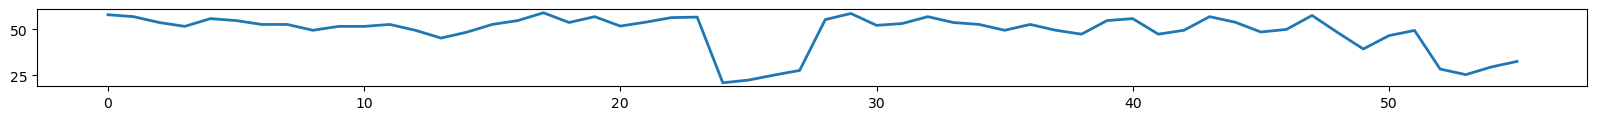

frequency:13 Hz    Mean Firing Rate(Hz): 48.76955032348633


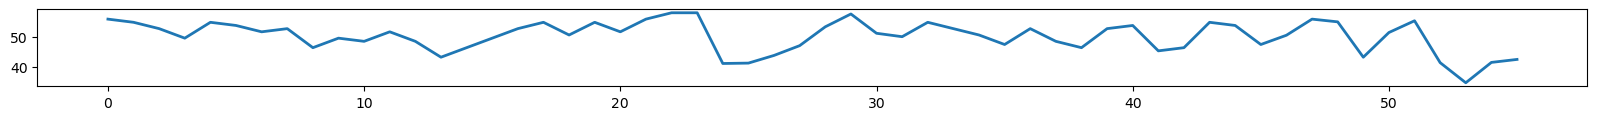

frequency:14 Hz    Mean Firing Rate(Hz): 50.108272552490234


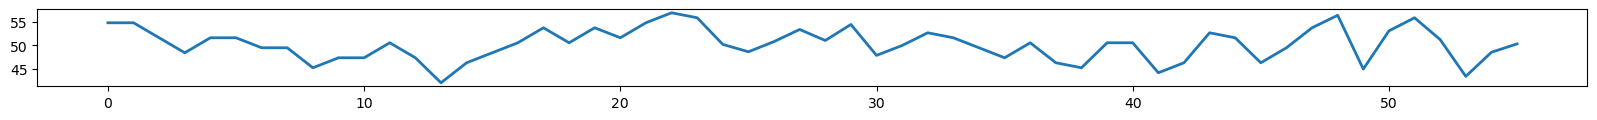

frequency:15 Hz    Mean Firing Rate(Hz): 50.21165084838867


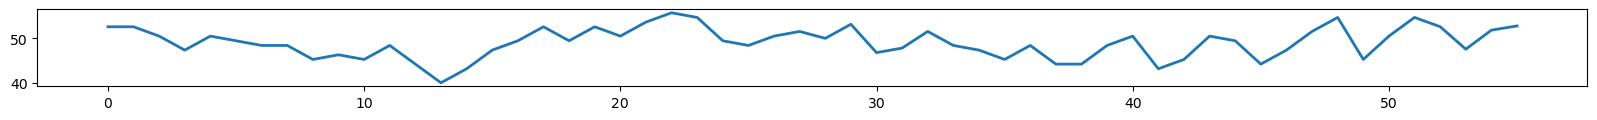

frequency:16 Hz    Mean Firing Rate(Hz): 49.053382873535156


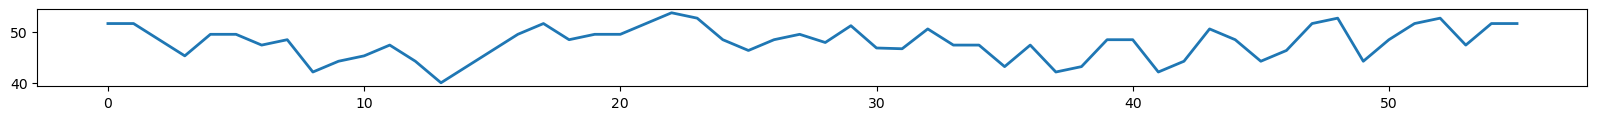

frequency:17 Hz    Mean Firing Rate(Hz): 47.873313903808594


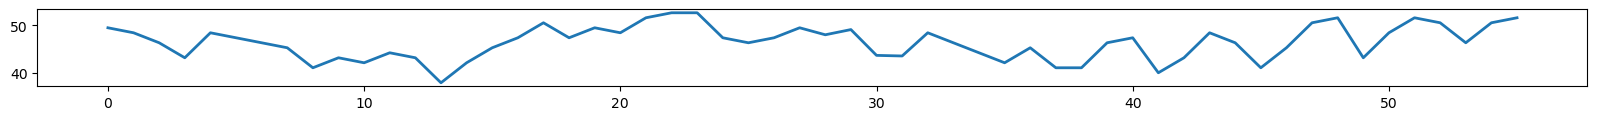

Trials: 100%|██████████| 1/1 [01:00<00:00, 60.63s/it]

frequency:18 Hz    Mean Firing Rate(Hz): 46.411277770996094


In [29]:
num_trials = 1
num_speed = range(1,19, 1) # Frequencies from 80 to 100 with a step of 1
num_stim = 1000
F = 0.5 
pixel_h = 64
pixel_w = 48
device = 'cpu'  
data = []
labels = []

# Run the trials
for trial in tqdm(range(num_trials), desc="Trials"):
    # Generate the stimuli for each frequency
    for speed in tqdm(num_speed, desc=f"Trial {trial+1} - mm/s speed", leave=False):
        # Generate the stimulus
        stim =  generate_speed_bar_stimuli(num_stim=1000, speed=speed, direction='vert', angle=0, pixel_h=64, pixel_w=48, F=10, show_frames=[])

        # plt.figure(figsize= (20,1))
        # plt.plot(stimulus[0, 0, :], linewidth=0.5)
        # plt.plot(torch.abs(torch.diff(stimulus[40, 40, :])) * 5, linewidth=0.5)
        # plt.title("Frequency: " + str(freq) + " Hz",fontsize = 12)
        # plt.tick_params(axis='both', which='major', labelsize=8)  # adjust the size here
        # plt.xlim([0, num_stim])
        # plt.show()

        S = SNN(R, device = device, noise_std_val = 2)  # Update with your SNN initialization method
        S.feedforward(stim)
        plot_figure = (trial == 0)

        mean_firing_rates = plot_SNN(S,layers = [],plot_figure = plot_figure,fig_size = (20,1))

        if trial == 0:
            print('frequency:' + str(speed) +' Hz   ' + ' Mean Firing Rate(Hz): ' + str(torch.mean(mean_firing_rates).item()))
        # if trial == 1:
        
        #     mean_firing_rates = plot_SNN(S,layers=['cn'],plot_figure = True,fig_size = (20,1))
        
        # plot_mean_firing_rates(S.ra_spike_times[0],bin_size = 50, fig_size = (20,1))

        # Save the data and labels
        data.append(mean_firing_rates.cpu().numpy())
        labels.append(speed)


Trials: 100%|██████████| 1/1 [00:56<00:00, 56.10s/it]


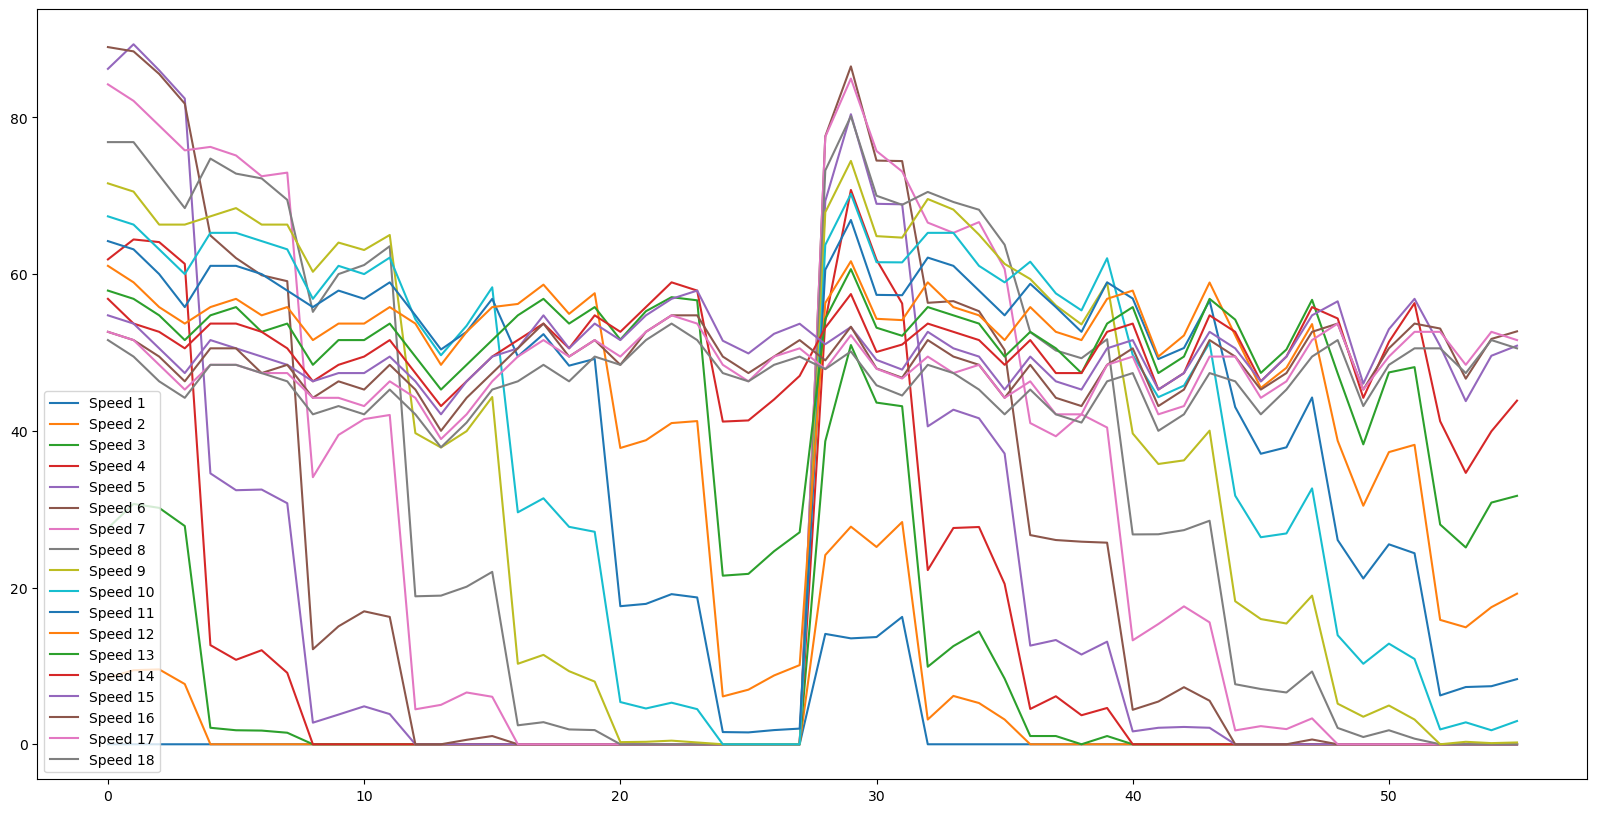

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))  # Create a figure and a set of subplots

# Run the trials
for trial in tqdm(range(num_trials), desc="Trials"):
    # Generate the stimuli for each frequency
    for speed in tqdm(num_speed, desc=f"Trial {trial+1} - mm/s speed", leave=False):
        # Generate the stimulus
        stim =  generate_speed_bar_stimuli(num_stim=1000, speed=speed, direction='vert', angle=0, pixel_h=64, pixel_w=48, F=10, show_frames=[])

        S = SNN(R, device = device, noise_std_val = 2)  # Update with your SNN initialization method
        S.feedforward(stim)

        mean_firing_rates = plot_SNN(S,layers = [],plot_figure = False,fig_size = (20,1))  # Set plot_figure to False

        # Plot the mean firing rates for each speed on the same figure
        ax.plot(mean_firing_rates.cpu().numpy(), label=f'Speed {speed}')

# Add a legend and show the plot
ax.legend()
plt.show()

In [28]:
# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

np.save('data_svm_angle.npy', data)
np.save('labels_svm_angle.npy', labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create and train the SVM
clf = svm.SVC(kernel='linear')  # You can change the kernel as needed
clf.fit(X_train, y_train)

# Test the SVM
y_pred = clf.predict(X_test)

# Print the accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# print(X_train.shape)
# print(X_test.shape)
# print(y_train)
# print(y_test)

# Identify the misclassified samples
misclassified = np.where(y_test != y_pred)

# Print the misclassified labels
print("Misclassified labels               : ", y_test[misclassified])
print("Test output of misclassified labels: ", y_pred[misclassified])
# Print the indices of the misclassified samples
# print("Indices of misclassified samples: ", misclassified)

Accuracy: 1.0
Misclassified labels               :  []
Test output of misclassified labels:  []
